In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pyreadstat as stat
import seaborn as sns
from pathlib import Path
import statsmodels.formula.api as smf

In [ ]:
# 1) Load the two files
gpa_traj = pd.read_csv("/Users/adamcartwright/ncerdc/Student Data/GPA Data/gpa_trajectories.csv")
demo     = pd.read_csv("/Users/adamcartwright/ncerdc/Student Data/Demographics Data/demographics_clean.csv")

# 2) Force mastid to numeric, drop invalid rows, cast to int
for df in (gpa_traj, demo):
    df["mastid"] = pd.to_numeric(df["mastid"], errors="coerce")
    df.dropna(subset=["mastid"], inplace=True)
    df["mastid"] = df["mastid"].astype(int)

# 3) Ensure 'year' is int **and then rename to 'year_end'**  
gpa_traj["year"] = gpa_traj["year"].astype(int)
demo   ["year"] = demo   ["year"].astype(int)
for df in (gpa_traj, demo):
    df.rename(columns={"year": "year_end"}, inplace=True)

# 4) Merge on mastid + year_end
merged = pd.merge(
    gpa_traj,
    demo,
    how="inner",
    on=["mastid", "year_end"]
)


# 5a) Drop invalid rows for SWD/SEX/EDS, but allow AIG ∈ {"Y","N","B","I","M","R"}
merged = merged[
    merged["swd"].isin(["Y","N"]) &
    merged["aig"].isin(["Y","N","B","I","M","R"]) &
    merged["sex"].isin(["M","F"]) &
    merged["eds"].isin(["Y","N"])
].copy()

# 5b) Map flags: treat any of Y, B, I, M, R as gifted (1), and N as non-gifted (0)
aig_map = {"Y":1, "B":1, "I":1, "M":1, "R":1, "N":0}
merged["SWD_flag"] = merged["swd"].map({"Y":1,"N":0}).astype(int)
merged["AIG_flag"] = merged["aig"].map(aig_map).astype(int)
merged["sex_flag"] = merged["sex"].map({"M":1,"F":0}).astype(int)
merged["EDS_flag"] = merged["eds"].map({"Y":1,"N":0}).astype(int)
merged["ethnic"]   = merged["ethnic"].astype("category")

# 6) Sort & compute grade strings
merged.sort_values(["mastid","year_end"], inplace=True)
merged["grade_int"] = merged.groupby("mastid").cumcount().add(9).clip(upper=12)
merged["grade"]     = merged["grade_int"].astype(str).str.zfill(2)
merged.drop(columns=["grade_int"], inplace=True)

# 7) Drop any observations **outside end‐years 2017–2023**  
#    (so you get academic years ’16–17 through ’22–23)
merged = merged[merged["year_end"].between(2017, 2023)].copy()

# 8) Compute each student's first & last year_end
merged["first_year_end"] = merged.groupby("mastid")["year_end"].transform("min")
merged["last_year_end"]  = merged.groupby("mastid")["year_end"].transform("max")

# 9) Keep only true freshman→senior spans:
df4 = (
    merged
    .groupby("mastid")
    .filter(lambda g: len(g)==4 and (g["last_year_end"].iloc[0] - g["first_year_end"].iloc[0] == 3))
    .copy()
)

# 10) Compute t = 0…3
df4["t"] = df4["year_end"] - df4["first_year_end"]

# 11) Label each row as pre/onset/post by **spring (end) year**:
#     ≤2019 → pre (ends spring ’19), 2020 → onset (sprang ’20), >2020 → post 
df4["period"] = pd.cut(
    df4["year_end"],
    bins=[-np.inf, 2019, 2020, np.inf],
    labels=["pre","onset","post"]
)

# 12) Keep only students whose 4-year run includes at least one onset year
df_covid = (
    df4
    .groupby("mastid")
    .filter(lambda g: (g["period"]=="onset").any())
    .query("t.between(0,3)")
    .copy()
)

# 13) Save clean COVID‐overlap trajectories
out_path = "/Users/adamcartwright/ncerdc/Trajectories Analysis/gpa_covid_overlap_clean.csv"
df_covid.to_csv(out_path, index=False)
print(f"Saved cleaned COVID-overlap GPA trajectories to {out_path}")

# 14) Sanity check
print("t values in df_covid:", sorted(df_covid["t"].unique()))
print("Counts by t & period:")
print(df_covid.groupby(["t","period"])["mastid"]
             .nunique()
             .unstack(fill_value=0))


/var/folders/1v/d265l3ks51x5svspj6rx8y3c0000gn/T/ipykernel_94532/2252807544.py:3: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  demo     = pd.read_csv("/Users/adamcartwright/ncerdc/Student Data/Demographics Data/demographics_clean.csv")


Saved cleaned COVID-overlap GPA trajectories to /Users/adamcartwright/ncerdc/Trajectories Analysis/gpa_covid_overlap_clean.csv
t values in df_covid: [np.int64(0), np.int64(1), np.int64(2), np.int64(3)]
Counts by t & period:
period     pre  onset    post
t                            
0       258727  97508       0
1       177276  81427   97505
2        89161  88131  178921
3            0  89169  267066


/var/folders/1v/d265l3ks51x5svspj6rx8y3c0000gn/T/ipykernel_94532/2252807544.py:92: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(df_covid.groupby(["t","period"])["mastid"]


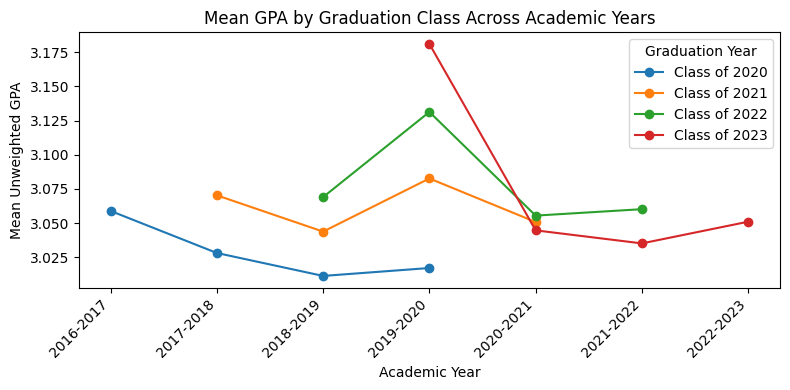

In [3]:
# assume df_covid has columns mastid, first_year, year, gpa_unweighted

# 1) compute graduation year (start + 3)
df_covid['grad_year'] = df_covid['first_year_end'] + 3

# 2) compute mean GPA by calendar year & graduation year
avg_by_year = (
    df_covid
      .groupby(['year_end','grad_year'])['gpa_unweighted']
      .mean()
      .unstack('grad_year')
)

# 3) plot with “Class of YYYY” legend
fig, ax = plt.subplots(figsize=(8,4))
for grad in avg_by_year.columns:
    ax.plot(
        avg_by_year.index,
        avg_by_year[grad],
        marker='o',
        label=f"Class of {int(grad)}"
    )
# 3) set custom year-span labels, rotated
years = avg_by_year.index.tolist()                      # [2017, 2018, …, 2023]
labels = [f"{y-1}-{y}" for y in years]                   # ["2016-2017", …, "2022-2023"]
ax.set_xticks(years)
ax.set_xticklabels(labels, rotation=45, ha='right')

# 4) rest of styling
ax.set_xlabel('Academic Year')
ax.set_ylabel('Mean Unweighted GPA')
ax.set_title('Mean GPA by Graduation Class Across Academic Years')
ax.legend(title='Graduation Year', bbox_to_anchor=(1,1))
plt.tight_layout()
plt.show()

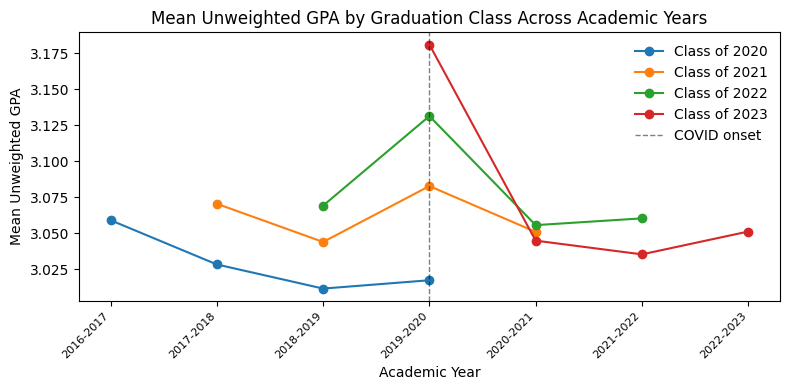

In [4]:
# 1) (re)compute grad_year if needed
df_covid['grad_year'] = df_covid['first_year_end'] + 3

# 2) compute mean unweighted GPA by calendar year & graduation year
avg_unwt_by_year = (
    df_covid
      .groupby(['year_end','grad_year'])['gpa_unweighted']
      .mean()
      .unstack('grad_year')
)

# 3) plot
fig, ax = plt.subplots(figsize=(8,4))

# plot each class
for grad in avg_unwt_by_year.columns:
    ax.plot(
        avg_unwt_by_year.index,
        avg_unwt_by_year[grad],
        marker='o',
        label=f"Class of {int(grad)}"
    )

# vertical COVID cutoff
COVID_YEAR = 2020
ax.axvline(
    x=COVID_YEAR,
    color='black',
    linestyle='--',
    linewidth=1,
    label='COVID onset',
    alpha=0.5
)

# academic‐year ticks
years  = avg_unwt_by_year.index.tolist()
labels = [f"{y-1}-{y}" for y in years]
ax.set_xticks(years)
ax.set_xticklabels(labels, rotation=45, ha='right', fontsize=8)

# labels & title
ax.set_xlabel('Academic Year')
ax.set_ylabel('Mean Unweighted GPA')
ax.set_title('Mean Unweighted GPA by Graduation Class Across Academic Years')

# legend inside
ax.legend(
    title='',
    loc='upper right',
    frameon=False
)

plt.tight_layout()
plt.show()

In [6]:
avg_wt_by_year = (
    df_covid
      .groupby(['year_end','grad_year'])['gpa_weighted']
      .mean()
      .unstack('grad_year')
)
# 1) Overall weighted‐GPA bump & drop
#    avg_wt_by_year.index are calendar years (e.g. 2019 for 2018–19)
overall = avg_wt_by_year.mean(axis=1)   # mean across all grad_years

pre   = overall.loc[2019]    # 2018–19
peak  = overall.loc[2020]    # 2019–20
post  = overall.loc[2021]    # 2020–21

print(f"Pre‑COVID: {pre:.2f} → {peak:.2f} (+{peak-pre:.2f})")
print(f"Pandemic: {peak:.2f} → {post:.2f} (−{peak-post:.2f})")

# 1) Overall unweighted‐GPA bump & drop
#    avg_unwt_by_year.index are calendar years (e.g. 2019 for 2018–19)
overall_unwt = avg_unwt_by_year.mean(axis=1)   # average across all grad_years

pre_unwt   = overall_unwt.loc[2019]    # 2018–19
peak_unwt  = overall_unwt.loc[2020]    # 2019–20
post_unwt  = overall_unwt.loc[2021]    # 2020–21

print(f"Pre-COVID: {pre_unwt:.2f} → {peak_unwt:.2f} (+{peak_unwt - pre_unwt:.2f})")
print(f"Pandemic:   {peak_unwt:.2f} → {post_unwt:.2f} (-{peak_unwt - post_unwt:.2f})")


Pre‑COVID: 3.22 → 3.20 (+-0.02)
Pandemic: 3.20 → 3.10 (−0.10)
Pre-COVID: 3.04 → 3.10 (+0.06)
Pandemic:   3.10 → 3.05 (-0.05)


In [7]:
# — 1) Build year‐to‐year GPA changes for each student —
# assume df4 has your cleaned 4-year data with columns 
# ['mastid','year','gpa_unweighted','AIG_flag','SWD_flag','sex_flag','ethnic']

slopes_yearly_unwt = (
    df_covid
    .sort_values(['mastid','year_end'])
    .groupby('mastid')
    .apply(lambda g: pd.DataFrame({
        'mastid':   g['mastid'].iloc[0],
        'to_year':  g['year_end'].values[1:],
        'slope_unwt':    g['gpa_unweighted'].values[1:] 
                   - g['gpa_unweighted'].values[:-1]
    }))
    .reset_index(drop=True)
)

# — 2) Classify each slope by the period of the 'to_year' —
def classify_period(year):
    if year <= 2020:
        return 'pre'
    elif year == 2021:
        return 'COVID'
    else:
        return 'post'

slopes_yearly_unwt['period'] = slopes_yearly_unwt['to_year'].apply(classify_period)

# — 3) Merge back student‐level covariates —
student_info = (
    df4
    .drop_duplicates('mastid')
    [['mastid','AIG_flag','SWD_flag', 'EDS_flag','sex_flag','ethnic']]
)
panel_unwt = slopes_yearly_unwt.merge(student_info, on='mastid')

# 1) Specify a formula that fully interacts period with each subgroup
formula = (
    'slope_unwt ~ C(period)*(AIG_flag + C(ethnic) + EDS_flag)'
)

# 2) Fit OLS with clustered SEs as before
model_unwt = smf.ols(
    formula = formula,
    data    = panel_unwt,
).fit(
    cov_type='cluster',
    cov_kwds={'groups': panel_unwt['mastid']}
)

# 3) Inspect the results
print(model_unwt.summary())


/var/folders/1v/d265l3ks51x5svspj6rx8y3c0000gn/T/ipykernel_94532/54240357.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: pd.DataFrame({


                            OLS Regression Results                            
Dep. Variable:             slope_unwt   R-squared:                       0.045
Model:                            OLS   Adj. R-squared:                  0.045
Method:                 Least Squares   F-statistic:                     1434.
Date:                Wed, 23 Jul 2025   Prob (F-statistic):               0.00
Time:                        13:42:59   Log-Likelihood:             2.4763e+05
No. Observations:             1068705   AIC:                        -4.952e+05
Df Residuals:                 1068678   BIC:                        -4.949e+05
Df Model:                          26                                         
Covariance Type:              cluster                                         
                                       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercep

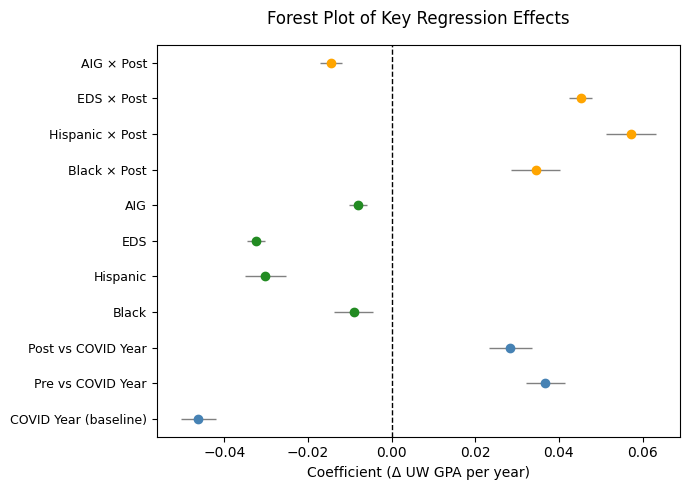

In [8]:
# 1) Terms in the order you want them plotted
terms = [
    'Intercept',
    'C(period)[T.pre]',
    'C(period)[T.post]',
    'C(ethnic)[T.B]',
    'C(ethnic)[T.H]',
    'EDS_flag',
    'AIG_flag',   # ← don’t forget the comma here!
    'C(period)[T.post]:C(ethnic)[T.B]',
    'C(period)[T.post]:C(ethnic)[T.H]',
    'C(period)[T.post]:EDS_flag',
    'C(period)[T.post]:AIG_flag'
]

# 2) Friendly labels for each term
label_map = {
    'Intercept':                       'COVID Year (baseline)',
    'C(period)[T.pre]':               'Pre vs COVID Year',
    'C(period)[T.post]':              'Post vs COVID Year',
    'C(ethnic)[T.B]':                 'Black',
    'C(ethnic)[T.H]':                 'Hispanic',
    'EDS_flag':                       'EDS',
    'AIG_flag':                       'AIG',
    'C(period)[T.post]:C(ethnic)[T.B]':'Black × Post',
    'C(period)[T.post]:C(ethnic)[T.H]':'Hispanic × Post',
    'C(period)[T.post]:EDS_flag':     'EDS × Post',
    'C(period)[T.post]:AIG_flag':     'AIG × Post'
}

# 3) One color per term (must be same length as `terms`)
colors = [
    'steelblue',  # Intercept
    'steelblue',  # Pre vs COVID
    'steelblue',  # Post vs COVID
    'forestgreen',# Black
    'forestgreen',# Hispanic
    'forestgreen',# EDS
    'forestgreen',# AIG
    'orange',     # Black × Post
    'orange',     # Hispanic × Post
    'orange',     # EDS × Post
    'orange',     # AIG × Post
]

# 4) Pull out the coefficients and 95% CIs from your fitted model
coef   = model_unwt.params.loc[terms]
ci     = model_unwt.conf_int().loc[terms]
ci_low = ci[0]
ci_hi  = ci[1]

# 5) Build the forest plot
y = np.arange(len(terms))
fig, ax = plt.subplots(figsize=(7, 5))

for i, term in enumerate(terms):
    # horizontal line for CI
    ax.hlines(y[i], ci_low[term], ci_hi[term], color='gray', linewidth=1)
    # point marker for estimate
    ax.plot(coef[term], y[i], 'o', color=colors[i], markersize=6)

# zero‐effect reference line
ax.axvline(0, color='black', linestyle='--', linewidth=1)

# 6) Format axes and labels
ax.set_yticks(y)
ax.set_yticklabels([label_map[t] for t in terms], fontsize=9)
ax.set_xlabel('Coefficient (Δ UW GPA per year)')
ax.set_title('Forest Plot of Key Regression Effects', pad=15)

plt.tight_layout()
plt.show()

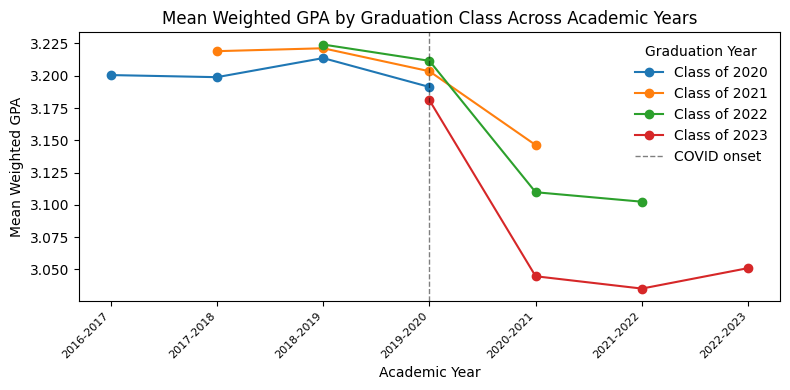

In [9]:
# 1) (re)compute grad_year if you haven’t already
df_covid['grad_year'] = df_covid['first_year_end'] + 3

# 2) compute mean *weighted* GPA by calendar year & graduation year
avg_wt_by_year = (
    df_covid
      .groupby(['year_end','grad_year'])['gpa_weighted']
      .mean()
      .unstack('grad_year')
)

# 3) plotting exactly as before, but using avg_wt_by_year
fig, ax = plt.subplots(figsize=(8,4))

# 1) Plot using the true grad_year for the legend
for grad in avg_wt_by_year.columns:
    ax.plot(
        avg_wt_by_year.index,
        avg_wt_by_year[grad],
        marker='o',
        label=f"Class of {int(grad)}"        # ← no +1 here
    )

# Draw the COVID cutoff as a dashed vertical line
COVID_YEAR = 2020
ax.axvline(
    x=COVID_YEAR,
    color='black',
    linestyle='--',
    linewidth=1,
    label='COVID onset',
    alpha = 0.5
)

# 2) Build academic-year tick labels correctly
years  = avg_wt_by_year.index.tolist()
labels = [f"{y-1}-{y}" for y in years]       # ← subtract 1 on the left side

ax.set_xticks(years)
ax.set_xticklabels(labels, rotation=45, ha='right', fontsize=8)

ax.set_xlabel('Academic Year')
ax.set_ylabel('Mean Weighted GPA')
ax.set_title('Mean Weighted GPA by Graduation Class Across Academic Years')
ax.legend(title='Graduation Year', bbox_to_anchor=(1,1))


ax.set_title('Mean Weighted GPA by Graduation Class Across Academic Years')
ax.legend(
    title='Graduation Year',
    loc='upper right',    # place legend inside at the upper right
    frameon=False         # optional: remove legend box for a cleaner look
)

plt.tight_layout()
plt.show()

In [10]:
# — 1) Build year-to-year GPA changes for each COVID-overlap student —
slopes_yearly_wt = (
    df_covid
    .sort_values(['mastid','year_end'])
    .groupby('mastid')
    .apply(lambda g: pd.DataFrame({
        'mastid':  g['mastid'].iloc[0],
        'to_year': g['year_end'].values[1:], 
        'slope_wt': g['gpa_weighted'].values[1:] 
                   - g['gpa_weighted'].values[:-1]
    }))
    .reset_index(drop=True)
)

# — 2) Classify each slope by the period of the 'to_year' —
def classify_period(end_yr):
    if   end_yr <= 2020: return 'pre'    # through spring 2020 = pre
    elif end_yr == 2021: return 'COVID'  # spring 2021 = onset
    else:                return 'post'   # 2022+ = post

slopes_yearly_wt['period'] = slopes_yearly_wt['to_year'].apply(classify_period)

# — 3) Merge back student-level covariates from df_covid —
student_info = (
    df_covid
    .drop_duplicates('mastid')
    [['mastid','AIG_flag','EDS_flag','ethnic']]
)
panel_wt = slopes_yearly_wt.merge(student_info, on='mastid')

# — 4) Specify & fit the fully‐interactive OLS with clustered SEs —
formula = 'slope_wt ~ C(period)*(AIG_flag + C(ethnic) + EDS_flag)'
model_wt = smf.ols(formula, data=panel_wt).fit(
    cov_type='cluster',
    cov_kwds={'groups': panel_wt['mastid']}
)

# — 5) Inspect results —
print(model_wt.summary())

/var/folders/1v/d265l3ks51x5svspj6rx8y3c0000gn/T/ipykernel_94532/3428997416.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: pd.DataFrame({


                            OLS Regression Results                            
Dep. Variable:               slope_wt   R-squared:                       0.054
Model:                            OLS   Adj. R-squared:                  0.054
Method:                 Least Squares   F-statistic:                     1904.
Date:                Wed, 23 Jul 2025   Prob (F-statistic):               0.00
Time:                        13:44:05   Log-Likelihood:             2.4126e+05
No. Observations:             1068705   AIC:                        -4.825e+05
Df Residuals:                 1068678   BIC:                        -4.822e+05
Df Model:                          26                                         
Covariance Type:              cluster                                         
                                       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercep

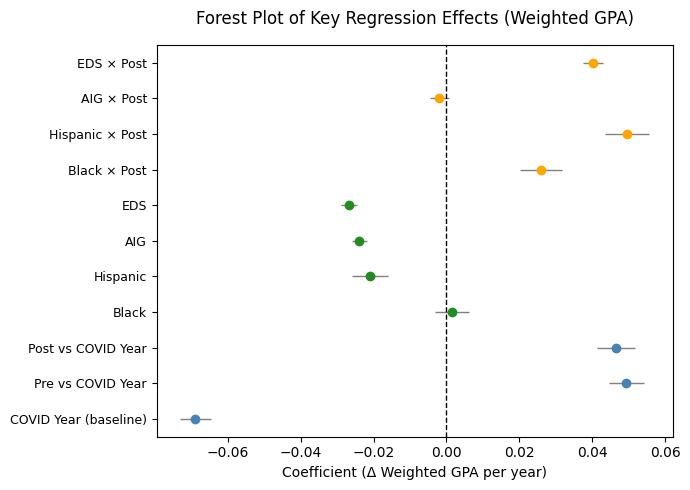

In [11]:
# 1) Terms in grouped order: baseline → period mains → subgroup mains → post‐period interactions
terms = [
    'Intercept',
    'C(period)[T.pre]',
    'C(period)[T.post]',
    'C(ethnic)[T.B]',
    'C(ethnic)[T.H]',
    'AIG_flag',
    'EDS_flag',                            # ← added
    'C(period)[T.post]:C(ethnic)[T.B]',
    'C(period)[T.post]:C(ethnic)[T.H]',
    'C(period)[T.post]:AIG_flag',
    'C(period)[T.post]:EDS_flag'           # ← added
]

# 2) Friendly labels
label_map = {
    'Intercept':                       'COVID Year (baseline)',
    'C(period)[T.pre]':               'Pre vs COVID Year',
    'C(period)[T.post]':              'Post vs COVID Year',
    'C(ethnic)[T.B]':                 'Black',
    'C(ethnic)[T.H]':                 'Hispanic',
    'AIG_flag':                       'AIG',
    'EDS_flag':                       'EDS',                    # ← added
    'C(period)[T.post]:C(ethnic)[T.B]':'Black × Post',
    'C(period)[T.post]:C(ethnic)[T.H]':'Hispanic × Post',
    'C(period)[T.post]:AIG_flag':     'AIG × Post',
    'C(period)[T.post]:EDS_flag':     'EDS × Post'              # ← added
}

# 3) Color by type (must match length of `terms`)
colors = [
    'steelblue',   # Intercept
    'steelblue',   # Pre vs COVID
    'steelblue',   # Post vs COVID
    'forestgreen', # Black
    'forestgreen', # Hispanic
    'forestgreen', # AIG
    'forestgreen', # EDS               ← added
    'orange',      # Black × Post
    'orange',      # Hispanic × Post
    'orange',      # AIG × Post
    'orange',      # EDS × Post       ← added
]

# 4) Extract coefs & CIs from your weighted‐GPA model
coef   = model_wt.params.loc[terms]
ci     = model_wt.conf_int().loc[terms]
ci_low = ci[0]
ci_hi  = ci[1]

# 5) Plot
y = np.arange(len(terms))
fig, ax = plt.subplots(figsize=(7, 5))

for i, term in enumerate(terms):
    ax.hlines(y[i], ci_low[term], ci_hi[term], color='gray', linewidth=1)
    ax.plot(coef[term], y[i], 'o', color=colors[i], markersize=6)

ax.axvline(0, color='black', linestyle='--', linewidth=1)

# 6) Labels & styling
ax.set_yticks(y)
ax.set_yticklabels([label_map[t] for t in terms], fontsize=9)
ax.set_xlabel('Coefficient (Δ Weighted GPA per year)')
ax.set_title('Forest Plot of Key Regression Effects (Weighted GPA)', pad=15)

plt.tight_layout()
plt.show()

In [12]:
# — assume you already have two panels:
#      panel_unwt = with slope_unweighted as your DV
#      panel_wt   = with slope_weighted   as your DV

# 1. Baseline (only period)
m1 = smf.ols('slope_unwt ~ C(period)',
             data=panel_unwt) \
     .fit(cov_type='cluster', cov_kwds={'groups': panel_unwt['mastid']})

# 2. + AIG
m2 = smf.ols('slope_unwt ~ C(period) + AIG_flag',
             data=panel_unwt) \
     .fit(cov_type='cluster', cov_kwds={'groups': panel_unwt['mastid']})
     
# 3. + EDS
m3 = smf.ols('slope_unwt ~ C(period) + AIG_flag + EDS_flag',
             data=panel_unwt) \
     .fit(cov_type='cluster', cov_kwds={'groups': panel_unwt['mastid']})

# 4. Weighted GPA model (same covariates as #3 but on weighted slope)
m4 = smf.ols('slope_wt ~ C(period) + AIG_flag + EDS_flag',
             data=panel_wt) \
     .fit(cov_type='cluster', cov_kwds={'groups': panel_wt['mastid']})


In [13]:
rows = []
for name, mod in [
     ('1. Period only',      m1),
     ('2. + AIG',            m2),
     ('3. + EDS',      m3),
     ('4. Weighted GPA (FE)' , m4),
]:
    rows.append({
        'Model': name,
        'R²_adj': mod.rsquared_adj,
        'AIC':    mod.aic,
        'BIC':    mod.bic
    })

summary_df = pd.DataFrame(rows)
print(summary_df)

                  Model    R²_adj            AIC            BIC
0        1. Period only  0.037389 -486921.199323 -486885.553449
1              2. + AIG  0.039804 -489605.382782 -489557.854950
2              3. + EDS  0.039968 -489787.076670 -489727.666879
3  4. Weighted GPA (FE)  0.049807 -477395.006776 -477335.596985


In [14]:
# pull out all p-values
pvals = model_unwt.pvalues

# show only ones > 0.05
non_sig = pvals[pvals > 0.05]
print(non_sig)

Series([], dtype: float64)


In [15]:
panel2 = panel_unwt[panel_unwt['ethnic'] != 'P'].copy()

# if 'ethnic' is already a Categorical dtype:
panel2['ethnic'] = panel2['ethnic'].cat.remove_unused_categories()

# if it’s not categorical yet (e.g. it’s strings), you can recast and drop unused:
panel2['ethnic'] = pd.Categorical(panel2['ethnic'])
panel2['ethnic'] = panel2['ethnic'].cat.remove_unused_categories()

# now refit:
formula = 'slope_unwt ~ C(period)*C(ethnic) + AIG_flag + EDS_flag'
m_step1 = smf.ols(formula, data=panel2) \
             .fit(cov_type='cluster', cov_kwds={'groups': panel2['mastid']})
print(m_step1.summary().tables[1])

                                       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercept                           -0.0503      0.002    -23.865      0.000      -0.054      -0.046
C(period)[T.post]                    0.0347      0.003     13.300      0.000       0.030       0.040
C(period)[T.pre]                     0.0419      0.002     17.774      0.000       0.037       0.046
C(ethnic)[T.B]                      -0.0239      0.002    -10.166      0.000      -0.029      -0.019
C(ethnic)[T.H]                      -0.0451      0.002    -18.379      0.000      -0.050      -0.040
C(ethnic)[T.I]                      -0.0504      0.005     -9.929      0.000      -0.060      -0.040
C(ethnic)[T.M]                      -0.0396      0.003    -12.571      0.000      -0.046      -0.033
C(ethnic)[T.W]                      -0.0270      0.002    -12.374      0.000      -0.031   

N students per grad_year:
last_year_end
2020    356676
2021    352524
2022    325708
2023    390032
Name: count, dtype: int64 

Class composition & GPA summary:
                n_students  mean_gpa   std_gpa   pct_AIG   pct_EDS   pct_SWD  \
last_year_end                                                                 
2020                89169  3.201123  0.804107  0.196758  0.374828  0.096715   
2021                88131  3.197553  0.772898  0.197697  0.344413  0.094575   
2022                81427  3.162015  0.737266  0.195958  0.321801  0.098297   
2023                97508  3.078025  0.720558  0.192756  0.342851  0.094651   

               pct_female  
last_year_end              
2020             0.499941  
2021             0.503705  
2022             0.500890  
2023             0.501354   

Ethnic composition (%):
 ethnic                A         B         H         I         M         P  \
last_year_end                                                               
2020          

/var/folders/1v/d265l3ks51x5svspj6rx8y3c0000gn/T/ipykernel_94532/3941259528.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(['last_year_end','ethnic'])['mastid']


Obs per (grad_year × academic year):
 year_end        2017   2018   2019   2020   2021   2022   2023
last_year_end                                                 
2020           89185  89152  89168  89171      0      0      0
2021               0  88131  88128  88134  88131      0      0
2022               0      0  81428  81430  81422  81428      0
2023               0      0      0  97512  97509  97500  97511 



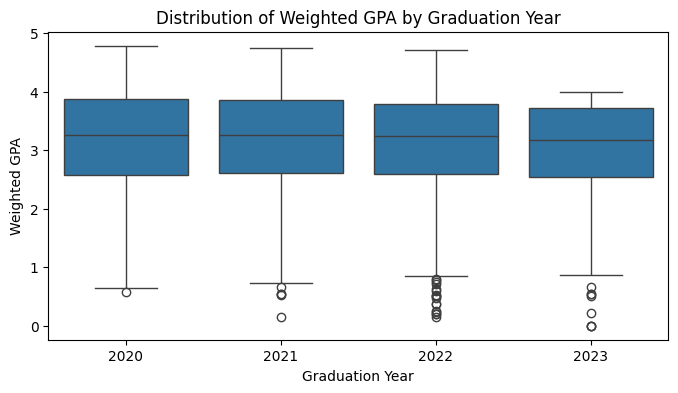

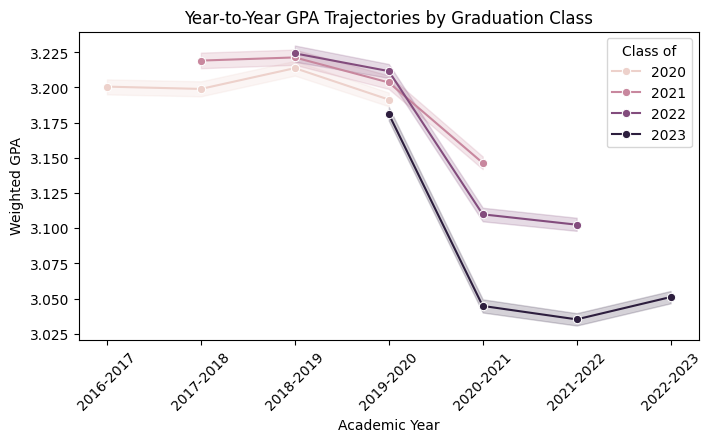

In [16]:
# 1) How big is each graduating class?
print("N students per grad_year:")
print(df_covid['last_year_end'].value_counts().sort_index(), "\n")

# 2) Basic summary by grad_year
summary = (
    df_covid
    .groupby('last_year_end')
    .agg(
        n_students    = ('mastid',     'nunique'),
        mean_gpa      = ('gpa_weighted','mean'),
        std_gpa       = ('gpa_weighted','std'),
        pct_AIG       = ('AIG_flag',    'mean'),
        pct_EDS       = ('EDS_flag',    'mean'),
        pct_SWD       = ('SWD_flag',    'mean'),
        pct_female    = ('sex_flag',    lambda x: 1 - x.mean()),
    )
)
print("Class composition & GPA summary:\n", summary, "\n")

# 3) Ethnic breakdown by class
ethnic_dist = (
    df_covid
    .groupby(['last_year_end','ethnic'])['mastid']
    .nunique()
    .unstack(fill_value=0)
)
ethnic_pct = ethnic_dist.div(ethnic_dist.sum(axis=1), axis=0)
print("Ethnic composition (%):\n", ethnic_pct, "\n")

# 4) Count of observations by (grad_year, year_end)
counts = (
    df_covid
    .groupby(['last_year_end','year_end'])
    .size()
    .unstack(fill_value=0)
)
print("Obs per (grad_year × academic year):\n", counts, "\n")

# 5) GPA distributions by grad_year
plt.figure(figsize=(8,4))
sns.boxplot(x='last_year_end', y='gpa_weighted', data=df_covid)
plt.title("Distribution of Weighted GPA by Graduation Year")
plt.xlabel("Graduation Year")
plt.ylabel("Weighted GPA")
plt.show()

# 6) Yearly trajectory faceted by class
plt.figure(figsize=(8,4))
sns.lineplot(
    data=df_covid,
    x='year_end', y='gpa_weighted',
    hue='last_year_end',
    marker='o'
)
plt.xticks(df_covid['year_end'].sort_values().unique(),
           [f"{y-1}-{y}" for y in sorted(df_covid['year_end'].unique())],
           rotation=45)
plt.title("Year‐to‐Year GPA Trajectories by Graduation Class")
plt.xlabel("Academic Year")
plt.ylabel("Weighted GPA")
plt.legend(title="Class of", loc='best')
plt.show()